In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/yehanliu/dvmt/metal-dev-2/")

from functools import partial

import numpy as np

import scqubits as scq


from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix, lumped_oscillator_from_path, extract_transmon_coupled_Noscillator
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem, QuantumSystemRegistry, QuantumBuilder
from qiskit_metal.analyses.hamiltonian.states_energies import extract_energies
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength

                        
from scipy.constants import speed_of_light as c_light
from pyEPR.calcs.constants import e_el as ele, hbar

import matplotlib.pyplot as plt
%matplotlib inline

06:11PM 13s INFO [__init__]: TransmonBuilder with system_type TRANSMON registered to QuantumSystemRegistry
06:11PM 13s INFO [__init__]: FluxoniumBuilder with system_type FLUXONIUM registered to QuantumSystemRegistry
06:11PM 13s INFO [__init__]: TLResonatorBuilder with system_type TL_RESONATOR registered to QuantumSystemRegistry
06:11PM 13s INFO [__init__]: LumpedResonatorBuilder with system_type LUMPED_RESONATOR registered to QuantumSystemRegistry


# Example: two transmons coupled by a direct coupler

### load transmon cell Q3d simulation results

In [2]:
path1 = './Q1_TwoTransmon_CapMatrix.txt'
ta_mat, _, _, _ = load_q3d_capacitance_matrix(path1)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Q1_TwoTransmon_CapMatrix.txt


,coupler_connector_pad_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
coupler_connector_pad_Q1,59.20,-37.28,-2.01,-19.11,-0.23
ground_main_plane,-37.28,246.33,-39.79,-39.86,-37.30
pad_bot_Q1,-2.01,-39.79,93.05,-30.61,-19.22
pad_top_Q1,-19.11,-39.86,-30.61,92.99,-2.01
readout_connector_pad_Q1,-0.23,-37.30,-19.22,-2.01,59.33


In [3]:
path2 = './Q2_TwoTransmon_CapMatrix.txt'
tb_mat, _, _, _ = load_q3d_capacitance_matrix(path2)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Q2_TwoTransmon_CapMatrix.txt


,coupler_connector_pad_Q2,ground_main_plane,pad_bot_Q2,pad_top_Q2,readout_connector_pad_Q2
coupler_connector_pad_Q2,64.52,-38.63,-2.18,-22.93,-0.22
ground_main_plane,-38.63,267.40,-49.28,-49.30,-38.67
pad_bot_Q2,-2.18,-49.28,121.38,-45.24,-23.06
pad_top_Q2,-22.93,-49.30,-45.24,121.24,-2.18
readout_connector_pad_Q2,-0.22,-38.67,-23.06,-2.18,64.70


### Create LOM cells from capacitance matrices

In [4]:
# cell 1: transmon Alice cell

opt1 = dict(
    node_rename = {'coupler_connector_pad_Q1': 'coupling', 'readout_connector_pad_Q1': 'readout_alice'}, 
    cap_mat = ta_mat,
    ind_dict = {('pad_top_Q1', 'pad_bot_Q1'):10},  # junction inductance in nH
    jj_dict = {('pad_top_Q1', 'pad_bot_Q1'):'j1'},
    cj_dict = {('pad_top_Q1', 'pad_bot_Q1'):2}, # junction capacitance in fF

)
cell_1 = Cell(opt1)


# cell 2: transmon Bob cell
opt2 = dict(
    node_rename = {'coupler_connector_pad_Q2': 'coupling', 'readout_connector_pad_Q2': 'readout_bob'},
    cap_mat = tb_mat,
    ind_dict = {('pad_top_Q2', 'pad_bot_Q2'): 12}, # junction inductance in nH
    jj_dict = {('pad_top_Q2', 'pad_bot_Q2'):'j2'},
    cj_dict = {('pad_top_Q2', 'pad_bot_Q2'):2}, # junction capacitance in fF

)
cell_2 = Cell(opt2)

### Make subsystems

In [5]:
# subsystem 1: transmon Alice
transmon_alice = Subsystem(name='transmon_alice', sys_type='TRANSMON', nodes=['j1'])


# subsystem 2: transmon Bob
transmon_bob = Subsystem(name='transmon_bob', sys_type='TRANSMON', nodes=['j2'])


# subsystem 3: Alice readout resonator
q_opts = dict(
    f_res = 8, # resonator dressed frequency in GHz
    Z0 = 50, # characteristic impedance in Ohm
    vp = 0.404314 * c_light # phase velocity 
)
res_alice = Subsystem(name='readout_alice', sys_type='TL_RESONATOR', nodes=['readout_alice'], q_opts=q_opts)


# subsystem 4: Bob readout resonator
q_opts = dict(
    f_res = 7.6, # resonator dressed frequency in GHz
    Z0 = 50, # characteristic impedance in Ohm
    vp = 0.404314 * c_light # phase velocity 
)
res_bob = Subsystem(name='readout_bob', sys_type='TL_RESONATOR', nodes=['readout_bob'], q_opts=q_opts)

### Creat the composite system from the cells and the subsystems

In [6]:
composite_sys = CompositeSystem(
    subsystems=[transmon_alice, transmon_bob, res_alice, res_bob], 
    cells=[cell_1, cell_2], 
    grd_node='ground_main_plane',
    nodes_force_keep=['readout_alice', 'readout_bob']
)

In [7]:
cg = composite_sys.circuitGraph()
print(cg)

node_jj_basis:
-------------

['j1', 'pad_bot_Q1', 'j2', 'pad_bot_Q2', 'readout_alice', 'readout_bob', 'coupling']

nodes_keep:
-------------

['j1', 'j2', 'readout_alice', 'readout_bob']


L_inv_k (reduced inverse inductance matrix):
-------------

                j1        j2  readout_alice  readout_bob
j1             0.1  0.000000            0.0          0.0
j2             0.0  0.083333            0.0          0.0
readout_alice  0.0  0.000000            0.0          0.0
readout_bob    0.0  0.000000            0.0          0.0

C_k (reduced capacitance matrix):
-------------

                      j1         j2  readout_alice  readout_bob
j1             63.185549  -0.766012       8.318893    -0.323188
j2             -0.766012  84.343548      -0.342145    10.039921
readout_alice   8.318893  -0.342145      55.591197    -0.144354
readout_bob    -0.323188  10.039921      -0.144354    60.347427




### Generate the hilberspace from the composite system, leveraging the scqubits package

In [78]:
hilbertspace = composite_sys.create_hilbertspace()
hilbertspace = composite_sys.add_interaction()
hilbertspace.hamiltonian()

06:47PM 56s INFO [__init__]: TransmonBuilder with system_type TRANSMON registered to QuantumSystemRegistry
06:47PM 56s INFO [__init__]: FluxoniumBuilder with system_type FLUXONIUM registered to QuantumSystemRegistry
06:47PM 56s INFO [__init__]: TLResonatorBuilder with system_type TL_RESONATOR registered to QuantumSystemRegistry
06:47PM 56s INFO [__init__]: LumpedResonatorBuilder with system_type LUMPED_RESONATOR registered to QuantumSystemRegistry


Quantum object: dims = [[10, 10, 3, 3], [10, 10, 3, 3]], shape = (900, 900), type = oper, isherm = True
Qobj data =
[[-24384.00898603+0.00000000e+00j      0.        +1.08232559e-01j
       0.        +0.00000000e+00j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j]
 [     0.        -1.08232559e-01j -16784.00898603+0.00000000e+00j
       0.        +1.53063953e-01j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j]
 [     0.        +0.00000000e+00j      0.        -1.53063953e-01j
   -9184.00898603+0.00000000e+00j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j]
 ...
 [     0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j ...  73269.11342615+0.00000000e+00j
       0.        +4.99608155e+02j      0.        +0.00000000e+00j]
 [     0.        +0.00000000e+00j      0.        +0.00000000e+00j
 

### Print the results

In [96]:
hamiltonian_results = composite_sys.hamiltonian_results(hilbertspace, evals_count=30)

Finished eigensystem.     

system frequencies in GHz:
--------------------------
{'transmon_alice': 6.053360688806875, 'transmon_bob': 4.798988322288831, 'readout_alice': 8.009054820710865, 'readout_bob': 7.604412010766988}

Chi matrices in MHz
--------------------------
                transmon_alice  transmon_bob  readout_alice  readout_bob
transmon_alice     -353.239816     -0.542895      -4.132854    -0.003120
transmon_bob         -0.542895   -263.940098      -0.001154    -1.460416
readout_alice        -4.132854     -0.001154       4.283111    -0.000017
readout_bob          -0.003120     -1.460416      -0.000017     3.829744


In [97]:
hamiltonian_results['chi_in_MHz'].to_dataframe()

,transmon_alice,transmon_bob,readout_alice,readout_bob
transmon_alice,-353.239816,-0.542895,-4.132854,-0.003120
transmon_bob,-0.542895,-263.940098,-0.001154,-1.460416
readout_alice,-4.132854,-0.001154,4.283111,-0.000017
readout_bob,-0.003120,-1.460416,-0.000017,3.829744


In [98]:
composite_sys.compute_gs()

                transmon_alice  transmon_bob  readout_alice  readout_bob
transmon_alice        0.000000     20.115410    -129.897537     3.275638
transmon_bob         20.115410      0.000000       2.678608  -111.508230
readout_alice      -129.897537      2.678608       0.000000     0.436190
readout_bob           3.275638   -111.508230       0.436190     0.000000

In [99]:
composite_sys.compute_gs().to_dataframe()

,transmon_alice,transmon_bob,readout_alice,readout_bob
transmon_alice,0.000000,20.115410,-129.897537,3.275638
transmon_bob,20.115410,0.000000,2.678608,-111.508230
readout_alice,-129.897537,2.678608,0.000000,0.436190
readout_bob,3.275638,-111.508230,0.436190,0.000000


In [100]:
transmon_alice.h_params

{'EJ': 16346.15128067812,
 'EC': 312.756868730393,
 'Q_zpf': 3.204353268e-19,
 'default_charge_op': Operator(op=array([[-22,   0,   0, ...,   0,   0,   0],
        [  0, -21,   0, ...,   0,   0,   0],
        [  0,   0, -20, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  20,   0,   0],
        [  0,   0,   0, ...,   0,  21,   0],
        [  0,   0,   0, ...,   0,   0,  22]]), add_hc=False)}

In [101]:
transmon_bob.h_params

{'EJ': 13621.792733898432,
 'EC': 234.3240926996763,
 'Q_zpf': 3.204353268e-19,
 'default_charge_op': Operator(op=array([[-22,   0,   0, ...,   0,   0,   0],
        [  0, -21,   0, ...,   0,   0,   0],
        [  0,   0, -20, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  20,   0,   0],
        [  0,   0,   0, ...,   0,  21,   0],
        [  0,   0,   0, ...,   0,   0,  22]]), add_hc=False)}

### ***********

### Time evolution simulation with Sequencing https://sequencing.readthedocs.io/en/latest/index.html

In [103]:
%config InlineBackend.figure_formats = ['svg']

from tqdm import tqdm
from functools import partial
import qutip

from sequencing import Qubit, Transmon, Cavity, System, get_sequence, sync, delay
from sequencing.calibration import fit_sine, fit_displacement, tune_rabi, tune_displacement, tune_drag

from qiskit_metal.analyses.quantization.lom_time_evolution_sim import lom_composite_sys_to_seq_sys

In [104]:
system = lom_composite_sys_to_seq_sys(composite_sys, hilbertspace, levels=[3, 3, 10, 10])

Finished eigensystem.     


In [105]:
alice = system.modes[1]

In [106]:
selective_sigma = 500 # ns

# tune selective qubit pulse using Rabi
with system.use_modes([alice]):
    with alice.temporarily_set(gaussian_pulse__sigma=selective_sigma):
        _, _, selective_qubit_amp = tune_rabi(
            system, system.fock(transmon_alice=0, transmon_bob=0, readout_alice=0, readout_bob=0), mode_name=alice.name, update=False, plot=False, verify=False
        )

100%|██████████| 51/51 [00:11<00:00,  4.26it/s]


In [107]:
def selective_rotation(qubit, angle, phase=0, detune=0, sigma=selective_sigma):
    with qubit.gaussian_pulse.temporarily_set(sigma=sigma, amp=selective_qubit_amp):
         qubit.rotate(np.pi, phase, detune=detune)

In [108]:
init_states = [
    (f'$|g{n}\\rangle$', system.fock(transmon_alice=0, readout_alice=n)) for n in range(4)
]

In [109]:
# Apply a selective pi pulse that is resonant
# with the qubit when the cavity is in |0>.
results = {}

seq = get_sequence(system)
selective_rotation(alice, np.pi)

for label, state in tqdm(init_states, desc='Initial states'):
    result = seq.run(state)
    results[label] = result

Initial states: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


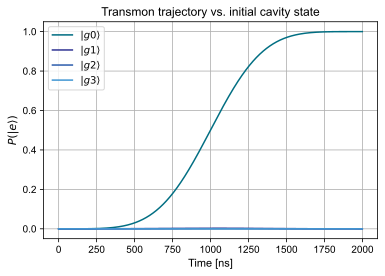

In [110]:
fig, ax = plt.subplots(1, 1)
for label, result in results.items():
    # trace over the cavity
    qubit_states = [state.ptrace(alice.index) for state in result.states]
    e_pops = qutip.expect(alice.fock_dm(1, full_space=False), qubit_states)
    ax.plot(result.times, e_pops, label=label)
    ax.grid(True)
    ax.legend(loc=0)
ax.set_xlabel('Time [ns]')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title('Transmon trajectory vs. initial cavity state')